# SON Algorithm Pipeline on Real-World Data

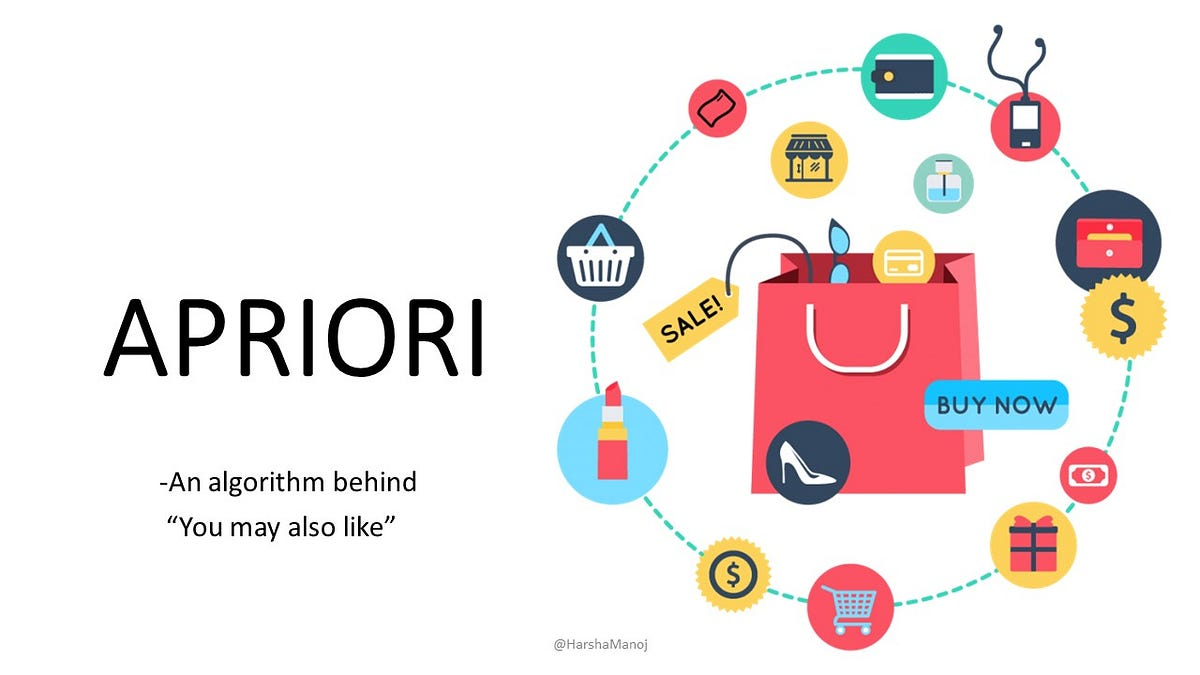

This notebook will also feature Apriori/SON Algorithm. <br>
However, one difference is that the initial data is raw. <br>
Here, I will not only utilize the algorithms but turn the notebook into a pipeline that will process the raw data into useful format.

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext, SparkConf

In [4]:
import pandas as pd
import sys
import time
import csv
from datetime import datetime
from itertools import combinations

In [5]:
conf = SparkConf().setAppName("task2").setMaster("local[*]")
sc = SparkContext(conf=conf)

#### Utility Functions:

- def custom_strip(iterator):
- def trim_date(dt):
- def reformat(row):
- def write_csv(directory,final_list):


In [6]:
def custom_strip(iterator):
    for i in range(0,len(iterator),1):
        iterator[i] = iterator[i].strip('"')
    return iterator

In [7]:
def trim_date(dt):
    dt = dt[:-2]
    return dt

In [8]:
def reformat(row):
    new_column = row[0]+'-'+row[1]
    newly_formatted = [new_column, row[2]]
    return newly_formatted

In [9]:
def write_csv(directory,final_list):
    with open(directory, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['DATE-CUSTOMER_ID','PRODUCT_ID'])
        for id in final_list:
            for product in id[1]:
                writer.writerow([id[0],product])
    file.close()

## Initial Data Format

Columns are as below:
- Trasnaction Date
- Customer ID
- Age Group
- Pin Code
- Product Subclass
- Product ID
- Amount
- Asset
- Sales Price

In [10]:
df = pd.read_csv('ta_feng_all_months_merged.csv')

In [41]:
len(df)

817741

In [11]:
df.head(10)

,TRANSACTION_DT,CUSTOMER_ID,AGE_GROUP,PIN_CODE,PRODUCT_SUBCLASS,PRODUCT_ID,AMOUNT,ASSET,SALES_PRICE
0,11/1/2000,1104905,45-49,115,110411,4710199010372,2,24,30
1,11/1/2000,418683,45-49,115,120107,4710857472535,1,48,46
2,11/1/2000,1057331,35-39,115,100407,4710043654103,2,142,166
3,11/1/2000,1849332,45-49,Others,120108,4710126092129,1,32,38
4,11/1/2000,1981995,50-54,115,100205,4710176021445,1,14,18
5,11/1/2000,1741797,35-39,115,110122,78895770025,1,54,75
6,11/1/2000,308359,60-64,115,110507,4710192225520,1,85,105
7,11/1/2000,1607000,35-39,221,520503,4712936888817,1,45,68
8,11/1/2000,1057331,35-39,115,320203,4715398106864,2,70,78
9,11/1/2000,236645,35-39,Unknown,120110,4710126091870,1,43,53


## Modified Format

To clearly identify the baskets, we need to consider the customer id and transaction date. <br>
Even if the transaction did not occur all at the same time, if the transaction date is the same, we consider them as a single basket. <br>
Moreover, since a customer can have multiple purchases throughout, to identify the basket uniquely, we will identify the basket by combinging the customer id and transaction date.

In [12]:
pre_rdd = sc.textFile('ta_feng_all_months_merged.csv').filter(lambda x: x != '"TRANSACTION_DT","CUSTOMER_ID","AGE_GROUP","PIN_CODE","PRODUCT_SUBCLASS","PRODUCT_ID","AMOUNT","ASSET","SALES_PRICE"').map(lambda x: x.split(",")).map(lambda x: custom_strip(x)).map(lambda x: (x[0],x[1].lstrip("0"),x[5].lstrip("0"))).map(lambda x: reformat(x)).groupByKey().mapValues(set)

In [13]:
final_list = pre_rdd.collect()

In [14]:
len(final_list)

119578

In [15]:
final_list[0]

('11/1/2000-418683',
 {'4710011401128', '4710011401135', '4710857472535', '4711524000891'})

## Save the Pre-processed Data

In [16]:
directory = 'processed_ta_feng.csv'

In [17]:
write_csv(directory,final_list)

## SON Algorithm

We will use two thresholds:
- Filter Threshold: We will use this value to filter initial baskets. 
- Support: We will use this value to determine whether an itemset is frequent enough.

In [18]:
filter_threshold = 20

In [19]:
support=50

In [20]:
rdd = sc.textFile(directory).filter(lambda x: x != "DATE-CUSTOMER_ID,PRODUCT_ID").map(lambda x: x.split(",")).groupByKey().mapValues(set).filter(lambda x: len(x[1])>filter_threshold).map(lambda x: x[1])

In [21]:
count = 10
for i in rdd.collect()[0]:
    if count > 0:
        print(i)
    count-=1

4711524000891
4901201101021
9310135026372
4710085120628
4711524000907
4714981010038
4710011405133
4710011409056
4710047502011
4710011406123


This value will be used to calculate rescaled support threshold.

In [22]:
total_count = rdd.flatMap(lambda x: x).count()
total_count

161276

#### def max_count_item_count(baskets):

This function returns the total number of items, as well as the biggest size basket. <br>
- Total Number of Items: will be used when applying SON algorithm (because SON algorithm intakes subsets of data at a time, we need to know the total number of items to proportionally reduce the threshold.
- Biggest Size Basket: will be used as a guide in terms of knowing how big of a combinations we must check for Apriori.

In [23]:
def max_count_item_count(baskets):
    max_count = 0
    temp_count = 0
    item_count = 0
    for basket in baskets:
        for item in basket:
            temp_count+=1
            item_count+=1 
        if temp_count > max_count:
            max_count = temp_count
        
        temp_count = 0
        
    return max_count, item_count

#### def single(baskets,item_count,sup,total):
This function counts the frequency of each unique items to determine whether they have surpassed the threshold.

* Because we are using SON algorithm, meaning we will handle subset of the data at a time, we need to recaliberate threshold value using # of items in the chunk, total colunt, and initial threshold value.

- The function utilizes hashing/dictionary to count the frequency of each item. And, if the frequency exceeds our threshold, we will add it to our set named result, which will be returned at the end.

In [24]:
def single(baskets,item_count,sup,total):
    
    result = set()
    temp_set = set()
    temp_dict = {}
    p = item_count / total * sup
    for basket in baskets:
        temp_set.update(basket)
        
    temp_set = {frozenset([item]) for item in temp_set}
    
    for item in temp_set:
        temp_dict[item] = 0
    
    for basket in baskets:
        for item in temp_dict:
            if item.issubset(basket):
                temp_dict[item] += 1
        
    for item in temp_dict:
        if temp_dict[item] >= p:
            result.add(item)
            
    return sorted(result)

#### def multiple(baskets,single_frequent,max_count,item_count,sup,total):
This function serves similarly to the function "single" but does it for pairs, triplets, and more. <br>

- This function utilizes the result from "single" function. It uses the frequent singletons to build its pairs and so on. 
- Iteratively, it will build frequent set from size of 2 to biggest existing basket size.

In [25]:
def multiple(baskets,single_frequent,max_count,item_count,sup,total):
    
    final_result = set()
    previous_frequent = single_frequent
    p = item_count / total * sup
    for size in range(2,max_count+1,1):
        temp_set = set()
        temp_dict = {}
        temp_result = set()
        for i in previous_frequent:
            for j in previous_frequent:
                if len(i.union(j)) == size:
                    temp_set.update({i.union(j)})
        
        for item in temp_set:
            temp_dict[item] = 0
            
        for basket in baskets:
            for item in temp_dict:
                if item.issubset(basket):
                    temp_dict[item] += 1
                
        for item in temp_dict:
            if temp_dict[item] >= p:
                temp_result.add(item)

        temp_result = sorted(temp_result)
        previous_frequent = temp_result
        final_result.update(temp_result)
                
    return final_result

#### def apriori(iterator,sup,total):

This function initiates the "single" and "multiple" function and aggregates the result into final candidates.

In [26]:
def apriori(iterator,sup,total):
    baskets = []
    for basket in iterator:
        baskets.append(basket)
        
    max_count, item_count = max_count_item_count(baskets)
    
    singleton = single(baskets,item_count,sup,total)
    multiplet = multiple(baskets,singleton,max_count,item_count,sup,total)
    
    final_candidate = set()
    final_candidate.update(singleton)
    final_candidate.update(multiplet)
    
    yield final_candidate

#### def frequent(iterator,candidate_list):
This function uses prior knowledge to determine truly frequent itemsets. 
- The function utilizes the result from function "apriori".

In [27]:
def frequent(iterator,candidate_list):
    
    final_candidate = []
    temp_dict = {}
    baskets = []
    item_count = max_count_item_count(baskets)[1]
    for basket in iterator:
        baskets.append(basket)
    
    for item in candidate_list:
        temp_dict[item[0]] = 0
        
    for basket in baskets:
        for item in temp_dict:
            if item.issubset(basket):
                temp_dict[item] += 1
                            
    for i in temp_dict:
        final_candidate.append((i,temp_dict[i]))

    return final_candidate

#### Utility Functions

These functions below assist in displaying the result in orderly way.

- def length_sort(x):
- def custom_sort(a_list):
- def custom_print(candidate,frequent,output_file):

In [28]:
def length_sort(x):
    if type(x) == int:
        return 1
    else:
        return len(x)

In [29]:
def custom_sort(a_list):
    dict_for_each = {}
    begin = "("
    end = ")"
    
    for frequent in a_list:
        temp_text = ""
        if frequent[-1] not in list(dict_for_each.keys()):
            dict_for_each[frequent[-1]] = []
        
        if frequent[-1] == 1:
            for i in frequent[0]:
                temp_text = temp_text + "('"+i+"')"
        
        else:
            count = frequent[-1]
            temp = 0
            for i in sorted(list(frequent[0])):
                temp+=1
                if temp != count:
                    temp_text = temp_text+"'"+str(i)+"'"+", "
                else:
                    temp_text = temp_text+"'"+str(i)+"'"
            
            temp_text = begin+temp_text+end
        
        dict_for_each[frequent[-1]].append(temp_text)
        
    total_list = []
    for i in sorted(dict_for_each):
        total_list.append(sorted(dict_for_each[i]))
    
    return total_list         

In [30]:
def custom_print(candidate,frequent,output_file):
    candidate_header = "Candidates:"
    frequent_header = "Frequent Itemsets:"
    
    with open(output_file,"w") as outfile:
        outfile.write(candidate_header)
        outfile.write("\n")
        for i in range(0,len(candidate),1):
            for j in range(0,len(candidate[i]),1):
                if j != len(candidate[i]) - 1:
                    outfile.write(candidate[i][j]+",")
                else:
                    outfile.write(candidate[i][j])       
            outfile.write("\n")
            outfile.write("\n")
        
        outfile.write(frequent_header)
        outfile.write("\n")
        for i in range(0,len(frequent),1):
            counter = 0
            for j in range(0,len(frequent[i]),1):
                counter = j
                if j != len(frequent[i]) - 1:
                    outfile.write(frequent[i][j]+",")
                else:
                    outfile.write(frequent[i][j])
            if i != len(frequent)-1 and counter != len(frequent[i][j])-1:
                outfile.write("\n")
                outfile.write("\n")
            
    outfile.close()

### Candidate 

From our raw data, we will now determine what itemsets can be candidates to becoming frequent itemsets. <br>

Below is an exapmle of our candidate (itemset). <br>
We have 4 candidates with 12, 30, 51, and 68 items in them.

In [31]:
candidate = rdd.mapPartitions(lambda x: apriori(x, support,total_count)).flatMap(lambda x:x).distinct().map(lambda x: (x,length_sort(x))).collect()

In [32]:
sorted_candidate = custom_sort(candidate)

In [40]:
len(sorted_candidate)

4

In [34]:
sorted_candidate[0][0:10]

["('20246013')",
 "('20246068')",
 "('20307585')",
 "('20332433')",
 "('20412074')",
 "('20415723')",
 "('20505233')",
 "('20535407')",
 "('20535414')",
 "('20546236')"]

### Frequent Item

From our candidates, we will determine which itemsets are truly frequent. <br>

Below is an example of our final frequent itemset.

In [35]:
frequent_item = rdd.mapPartitions(lambda x: frequent(x,candidate)).reduceByKey(lambda a,b:a+b).filter(lambda x: x[1] >= support).map(lambda x: (x[0],length_sort(x[0]))).collect()

In [36]:
sorted_frequent_item = custom_sort(frequent_item)

In [37]:
len(sorted_frequent_item)

4

In [43]:
for i in sorted_frequent_item:
    print(len(i[1]))

12
34
51
68


In [39]:
sorted_frequent_item[0][0:10]

["('20246013')",
 "('20307585')",
 "('20332433')",
 "('20412074')",
 "('20415723')",
 "('20535407')",
 "('20535414')",
 "('20546236')",
 "('20556372')",
 "('20557003')"]

## Conclusion

We started out with 817741 rows. <br>
Those rows were reformatted into 119578 unique key. <br>
After filtering baskets with less than 20 items, we have reached unique 161276 items. <br> <br>

When put through our pipeline, those data points turned into 4 candidates, which eventually all came out as frequent. <br>
By creating a pipeline using distributed programming, we were able to digest raw data into useful insight duration a short duration. 


